# PREDICTING PAY WITH OTHER INDICATORS

### WHAT FACTORS CONTIBUTES TO GENDER PAY GAP IN 2022

### PREPARE DATA

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline


#### IMPORT 

In [2]:
#read in the data and inspect for cleaning
df = pd.read_excel('/Users/Cheryl/Downloads/WBL-1971-2022-Dataset-Updated.xlsx', sheet_name=2)
print(df.shape)
print(df.info())
df.head()

(190, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Economy           190 non-null    object 
 1   ISO Code          190 non-null    object 
 2   Region            190 non-null    object 
 3   Income Group      190 non-null    object 
 4   WBL INDEX         190 non-null    float64
 5   MOBILITY          190 non-null    int64  
 6   WORKPLACE         190 non-null    int64  
 7   PAY               190 non-null    int64  
 8   MARRIAGE          190 non-null    int64  
 9   PARENTHOOD        190 non-null    int64  
 10  ENTREPRENEURSHIP  190 non-null    int64  
 11  ASSETS            190 non-null    int64  
 12  PENSION           190 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 19.4+ KB
None


,Economy,ISO Code,Region,Income Group,WBL INDEX,MOBILITY,WORKPLACE,PAY,MARRIAGE,PARENTHOOD,ENTREPRENEURSHIP,ASSETS,PENSION
0,Afghanistan,AFG,South Asia,Low income,38.125,50,75,0,20,20,75,40,25
1,Albania,ALB,Europe & Central Asia,Upper middle income,91.250,100,100,100,100,80,100,100,50
2,Algeria,DZA,Middle East & North Africa,Lower middle income,57.500,75,75,50,60,60,75,40,25
3,Angola,AGO,Sub-Saharan Africa,Lower middle income,79.375,100,100,50,100,60,100,100,25
4,Antigua and Barbuda,ATG,Latin America & Caribbean,High income,66.250,75,50,75,100,0,75,80,75


In [3]:
#summary statistics
df.describe()

,WBL INDEX,MOBILITY,WORKPLACE,PAY,MARRIAGE,PARENTHOOD,ENTREPRENEURSHIP,ASSETS,PENSION
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,76.546053,88.552632,80.526316,68.684211,80.105263,55.578947,84.342105,81.157895,73.421053
std,17.015774,20.984622,29.022648,29.873725,27.487168,31.629997,17.104219,26.760278,25.924832
min,26.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,67.031250,75.000000,50.000000,50.000000,60.000000,40.000000,75.000000,60.000000,50.000000
50%,80.000000,100.000000,100.000000,75.000000,100.000000,60.000000,75.000000,100.000000,75.000000
75%,88.125000,100.000000,100.000000,100.000000,100.000000,80.000000,100.000000,100.000000,100.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


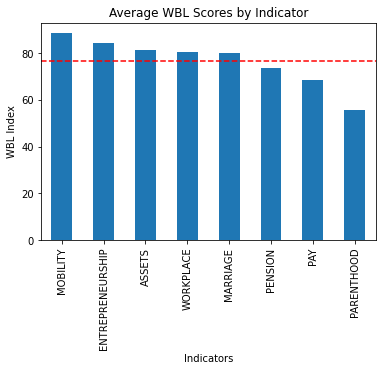

In [4]:
mean_indicator = df[['MOBILITY', 'WORKPLACE', 'PAY', 'MARRIAGE', 'PARENTHOOD', 'ENTREPRENEURSHIP', 'ASSETS', 'PENSION']].mean().sort_values(ascending=False)
mean_WBL_index = df["WBL INDEX"].mean()

mean_indicator.plot(kind="bar")
plt.axhline(mean_WBL_index, linestyle="--", color="red", label="Global avearge 76.5")
plt.xlabel("Indicators")
plt.ylabel("WBL Index")
plt.title("Average WBL Scores by Indicator");

Income Group
High income            86.348684
Upper middle income    77.884615
Lower middle income    70.340909
Low income             65.504808
Name: WBL INDEX, dtype: float64


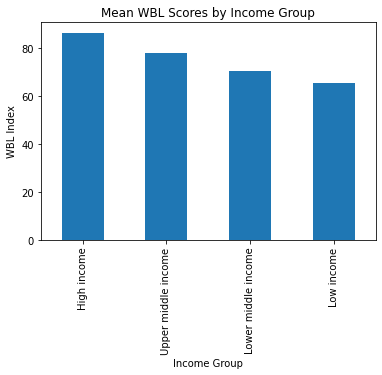

In [5]:
mean_pay_by_income_group = df.groupby("Income Group")["WBL INDEX"].mean().sort_values(ascending=False)
print(mean_pay_by_income_group)
mean_pay_by_income_group.plot(kind="bar", xlabel="Income Group", ylabel="WBL Index", title="Mean WBL Scores by Income Group");

#### EXPLORE

In [6]:
# Drop leaky column
df.drop(columns="WBL INDEX", inplace=True)

In [7]:
# Drop low- and high-cardinality categorical features
df.drop(columns=["Economy", "ISO Code", "Region", "Income Group"])

,MOBILITY,WORKPLACE,PAY,MARRIAGE,PARENTHOOD,ENTREPRENEURSHIP,ASSETS,PENSION
0,50,75,0,20,20,75,40,25
1,100,100,100,100,80,100,100,50
2,75,75,50,60,60,75,40,25
3,100,100,50,100,60,100,100,25
4,75,50,75,100,0,75,80,75
...,...,...,...,...,...,...,...,...
185,100,100,100,100,80,100,100,0
186,25,25,0,20,0,75,40,25
187,25,25,25,0,0,75,40,25
188,75,100,100,80,40,100,80,75


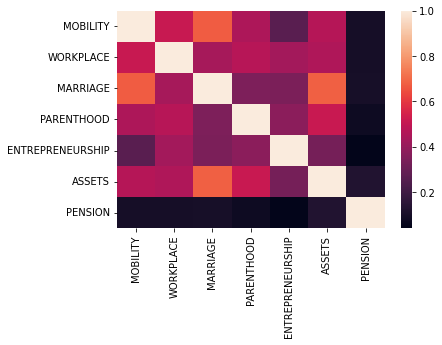

In [8]:
# Check for Multicollinearity
corr = df.drop(columns = ["PAY"]).corr()
sns.heatmap(corr);

In [9]:
print("corr1:", df["PAY"].corr(df["ASSETS"]))
print("corr2:", df["PAY"].corr(df["MARRIAGE"]))
print("corr3:",df["PAY"].corr(df["MOBILITY"]))

corr1: 0.2507706840182652
corr2: 0.3713125898715267
corr3: 0.37464055924993955


In [10]:
# Drop multicollinearity column
df.drop(columns=["ASSETS", "MARRIAGE", "MOBILITY"], inplace=True)

#### SPLIT

In [12]:
# Create feature matrix "X_train" and target vector "y_train"
target = "PAY"
features = ['WORKPLACE', 'PARENTHOOD', 'ENTREPRENEURSHIP', 'PENSION']
X_train = df[features]
y_train = df[target]

### BUILD MODEL

#### BASELINE

In [13]:
# Calculate the baseline mean absolute error
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean PAY:", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean PAY: 68.68
Baseline MAE: 25.34


#### ITERATE

In [14]:
# Create a pipeline named "model" 
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LinearRegression()
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=[], use_cat_names=True)),
                ('linearregression', LinearRegression())])

### EVALUATE

In [15]:
# Calculate the training mean absolute error
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 21.71


Our model beats the baseline by 4.02! That's a good indicator that will be helpful in predicting pay. 

In [16]:
X_train.head()

,WORKPLACE,PARENTHOOD,ENTREPRENEURSHIP,PENSION
0,75,20,75,25
1,100,80,100,50
2,75,60,75,25
3,100,60,100,25
4,50,0,75,75


In [17]:
# Make sure the order of columns in X_test is the same as in the X_train
X_test = pd.read_excel('/Users/Cheryl/Downloads/WBL-1971-2022-Dataset-Updated.xlsx', sheet_name=3)
X_test.head()

,WORKPLACE,PARENTHOOD,ENTREPRENEURSHIP,PENSION
0,75,20,75,25
1,100,80,100,50
2,75,60,75,25
3,50,60,100,25
4,50,0,75,75


In [18]:
# Check test performance
X_test = pd.read_excel('/Users/Cheryl/Downloads/WBL-1971-2022-Dataset-Updated.xlsx', sheet_name=3)[features]
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53.515100
1    76.361601
2    59.667927
3    55.865648
4    50.782376
dtype: float64

In [19]:
# Calculate the test mean absolute error
mae_test = mean_absolute_error(y_train, y_test_pred)
print("Test MAE:", round(mae_test, 2))

Test MAE: 21.99


Our test performance is about the same as our training performance. The training (21.71) and test performance (21.99) are close to each other, this means our model will generalize well. 

### COMMUNICATE RESULTS

In [20]:
# Extract the intercepts from the model and assign to the variable intercepts
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
print(coefficients)

[0.27596311 0.15382069 0.12387194 0.14485535]


In [21]:
# Extract feature names 
feature_names = model.named_steps["onehotencoder"].get_feature_names()
feature_names

['WORKPLACE', 'PARENTHOOD', 'ENTREPRENEURSHIP', 'PENSION']

In [22]:
# Pandas series where the index is "features" and values are the "coefficients"
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

WORKPLACE           0.275963
PARENTHOOD          0.153821
ENTREPRENEURSHIP    0.123872
PENSION             0.144855
dtype: float64

In [23]:
# Print the equation for predicting pay based on WBL indicators
print(f"PAY = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f" + ({round(c, 2)} + {f})")

PAY = 16.83
 + (0.28 + WORKPLACE)
 + (0.15 + PARENTHOOD)
 + (0.12 + ENTREPRENEURSHIP)
 + (0.14 + PENSION)


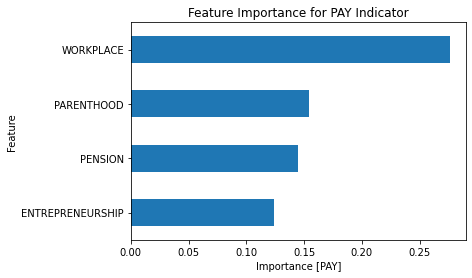

In [24]:
# Horizontal bar chart showing the top coefficients for your model
feat_imp.sort_values(key=abs).plot(kind="barh")
plt.xlabel("Importance [PAY]")
plt.ylabel("Feature")
plt.title("Feature Importance for PAY Indicator");

Looking at this bar chart, you can see that the most important indicators are "Workplace" and "Parenthood" for your model in predicting equal pay.  